# Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf

!pip install shap
import shap

from keras import backend as K

2023-08-06 11:13:57.357634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Import Data
train_plyrs = pd.read_csv('Train Test Data/arb_train_plyrs.csv')
test_plyrs = pd.read_csv('Train Test Data/arb_test_plyrs.csv')

for i in [train_plyrs, test_plyrs]:
    i.drop('index', axis = 1, inplace=True)

In [3]:
test_plyrs.head()

,Name,Prev. Season,Position,Service Time,Salary,Age,G,PA,H,1B,...,BsR,Inn,E,DRS,UZR,RAA,FRM,SB_def,CS_def,Prev. Salary
0,Abraham Toro,2022,3B,2,1250000,25,109,352,60,36,...,-1.1,599.33,6,0,-2.7,0,0.0,0,0,730300.0
1,Adalberto Mondesi,2022,SS,5,3045000,26,15,54,7,7,...,1.0,131.00,0,1,1.4,3,0.0,0,0,3000000.0
2,Alex Verdugo,2022,RF,4,6300000,26,152,644,166,115,...,-1.1,1305.30,5,-5,-0.9,-4,0.0,0,0,3550000.0
3,Amed Rosario,2022,SS,5,7800000,26,153,670,180,134,...,1.5,1286.00,14,4,6.3,-5,0.0,0,0,4950000.0
4,Andrew Knizner,2022,C,3,1100000,27,97,293,56,42,...,-1.8,692.30,6,-9,0.0,0,-8.7,21,7,718300.0


# EDA

## Descriptive Stats

In [4]:
train_plyrs.columns

Index(['Name', 'Prev. Season', 'Position', 'Service Time', 'Salary', 'Age',
       'G', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'AVG', 'RBI', 'BB', 'IBB',
       'SO', 'HBP', 'SF', 'SH', 'GDP', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG',
       'OPS', 'BABIP', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFH%', 'BUH%', 'HR/FB',
       'wGDP', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'TTO%',
       'wOBA', 'ISO', 'wRAA', 'wRC', 'wRC+', 'RE24', 'WAR', 'WPA', 'neg_WPA',
       'pos_WPA', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%',
       'Contact%', 'F-Strike%', 'SwStr%', 'wSB', 'SB_run', 'CS_run', 'UBR',
       'Spd', 'BsR', 'Inn', 'E', 'DRS', 'UZR', 'RAA', 'FRM', 'SB_def',
       'CS_def', 'Prev. Salary'],
      dtype='object')

In [5]:
# Descriptive stats, subset of continuous features
train_plyrs.describe().transpose().head(19)

,count,mean,std,min,25%,50%,75%,max
Prev. Season,875.0,2.016303e+03,3.172166e+00,2011.0,2.014000e+03,2016.000,2019.000,2021.00
Service Time,875.0,3.530286e+00,9.506997e-01,2.0,3.000000e+00,3.000,4.000,6.00
Salary,875.0,3.886930e+06,3.558940e+06,515000.0,1.500000e+06,2800000.000,4800000.000,27000000.00
Age,875.0,2.744229e+01,2.080704e+00,21.0,2.600000e+01,27.000,29.000,38.00
G,875.0,1.051051e+02,4.104761e+01,0.0,7.250000e+01,114.000,140.000,162.00
PA,875.0,3.860377e+02,1.842553e+02,0.0,2.330000e+02,384.000,544.500,747.00
H,875.0,8.922971e+01,4.782100e+01,0.0,5.100000e+01,85.000,125.000,213.00
1B,875.0,5.741943e+01,3.195576e+01,0.0,3.200000e+01,55.000,78.500,162.00
2B,875.0,1.783429e+01,1.043959e+01,0.0,9.000000e+00,17.000,25.000,47.00
3B,875.0,1.949714e+00,2.248770e+00,0.0,0.000000e+00,1.000,3.000,15.00


In [6]:
# Descriptive stats, last 10 stats
train_plyrs.describe().transpose().tail(10)

,count,mean,std,min,25%,50%,75%,max
BsR,875.0,4.451429e-01,2.844390e+00,-9.8,-1.20,0.2,1.800,13.6
Inn,875.0,7.658268e+02,3.724416e+02,0.0,453.17,774.0,1095.315,1435.0
E,875.0,5.393143e+00,4.837492e+00,0.0,2.00,4.0,8.000,27.0
DRS,875.0,1.112000e+00,7.575480e+00,-28.0,-3.00,0.0,5.000,33.0
UZR,875.0,5.160000e-01,4.446946e+00,-15.6,-1.50,0.0,2.300,26.7
RAA,875.0,3.748571e-01,3.901688e+00,-20.0,0.00,0.0,0.000,26.0
FRM,875.0,3.860571e-01,3.674828e+00,-18.1,0.00,0.0,0.000,28.8
SB_def,875.0,6.240000e+00,1.600370e+01,0.0,0.00,0.0,0.000,101.0
CS_def,875.0,2.345143e+00,6.494124e+00,0.0,0.00,0.0,0.000,44.0
Prev. Salary,657.0,2.611505e+06,2.793192e+06,100000.0,614000.00,1725000.0,3300000.000,20000000.0


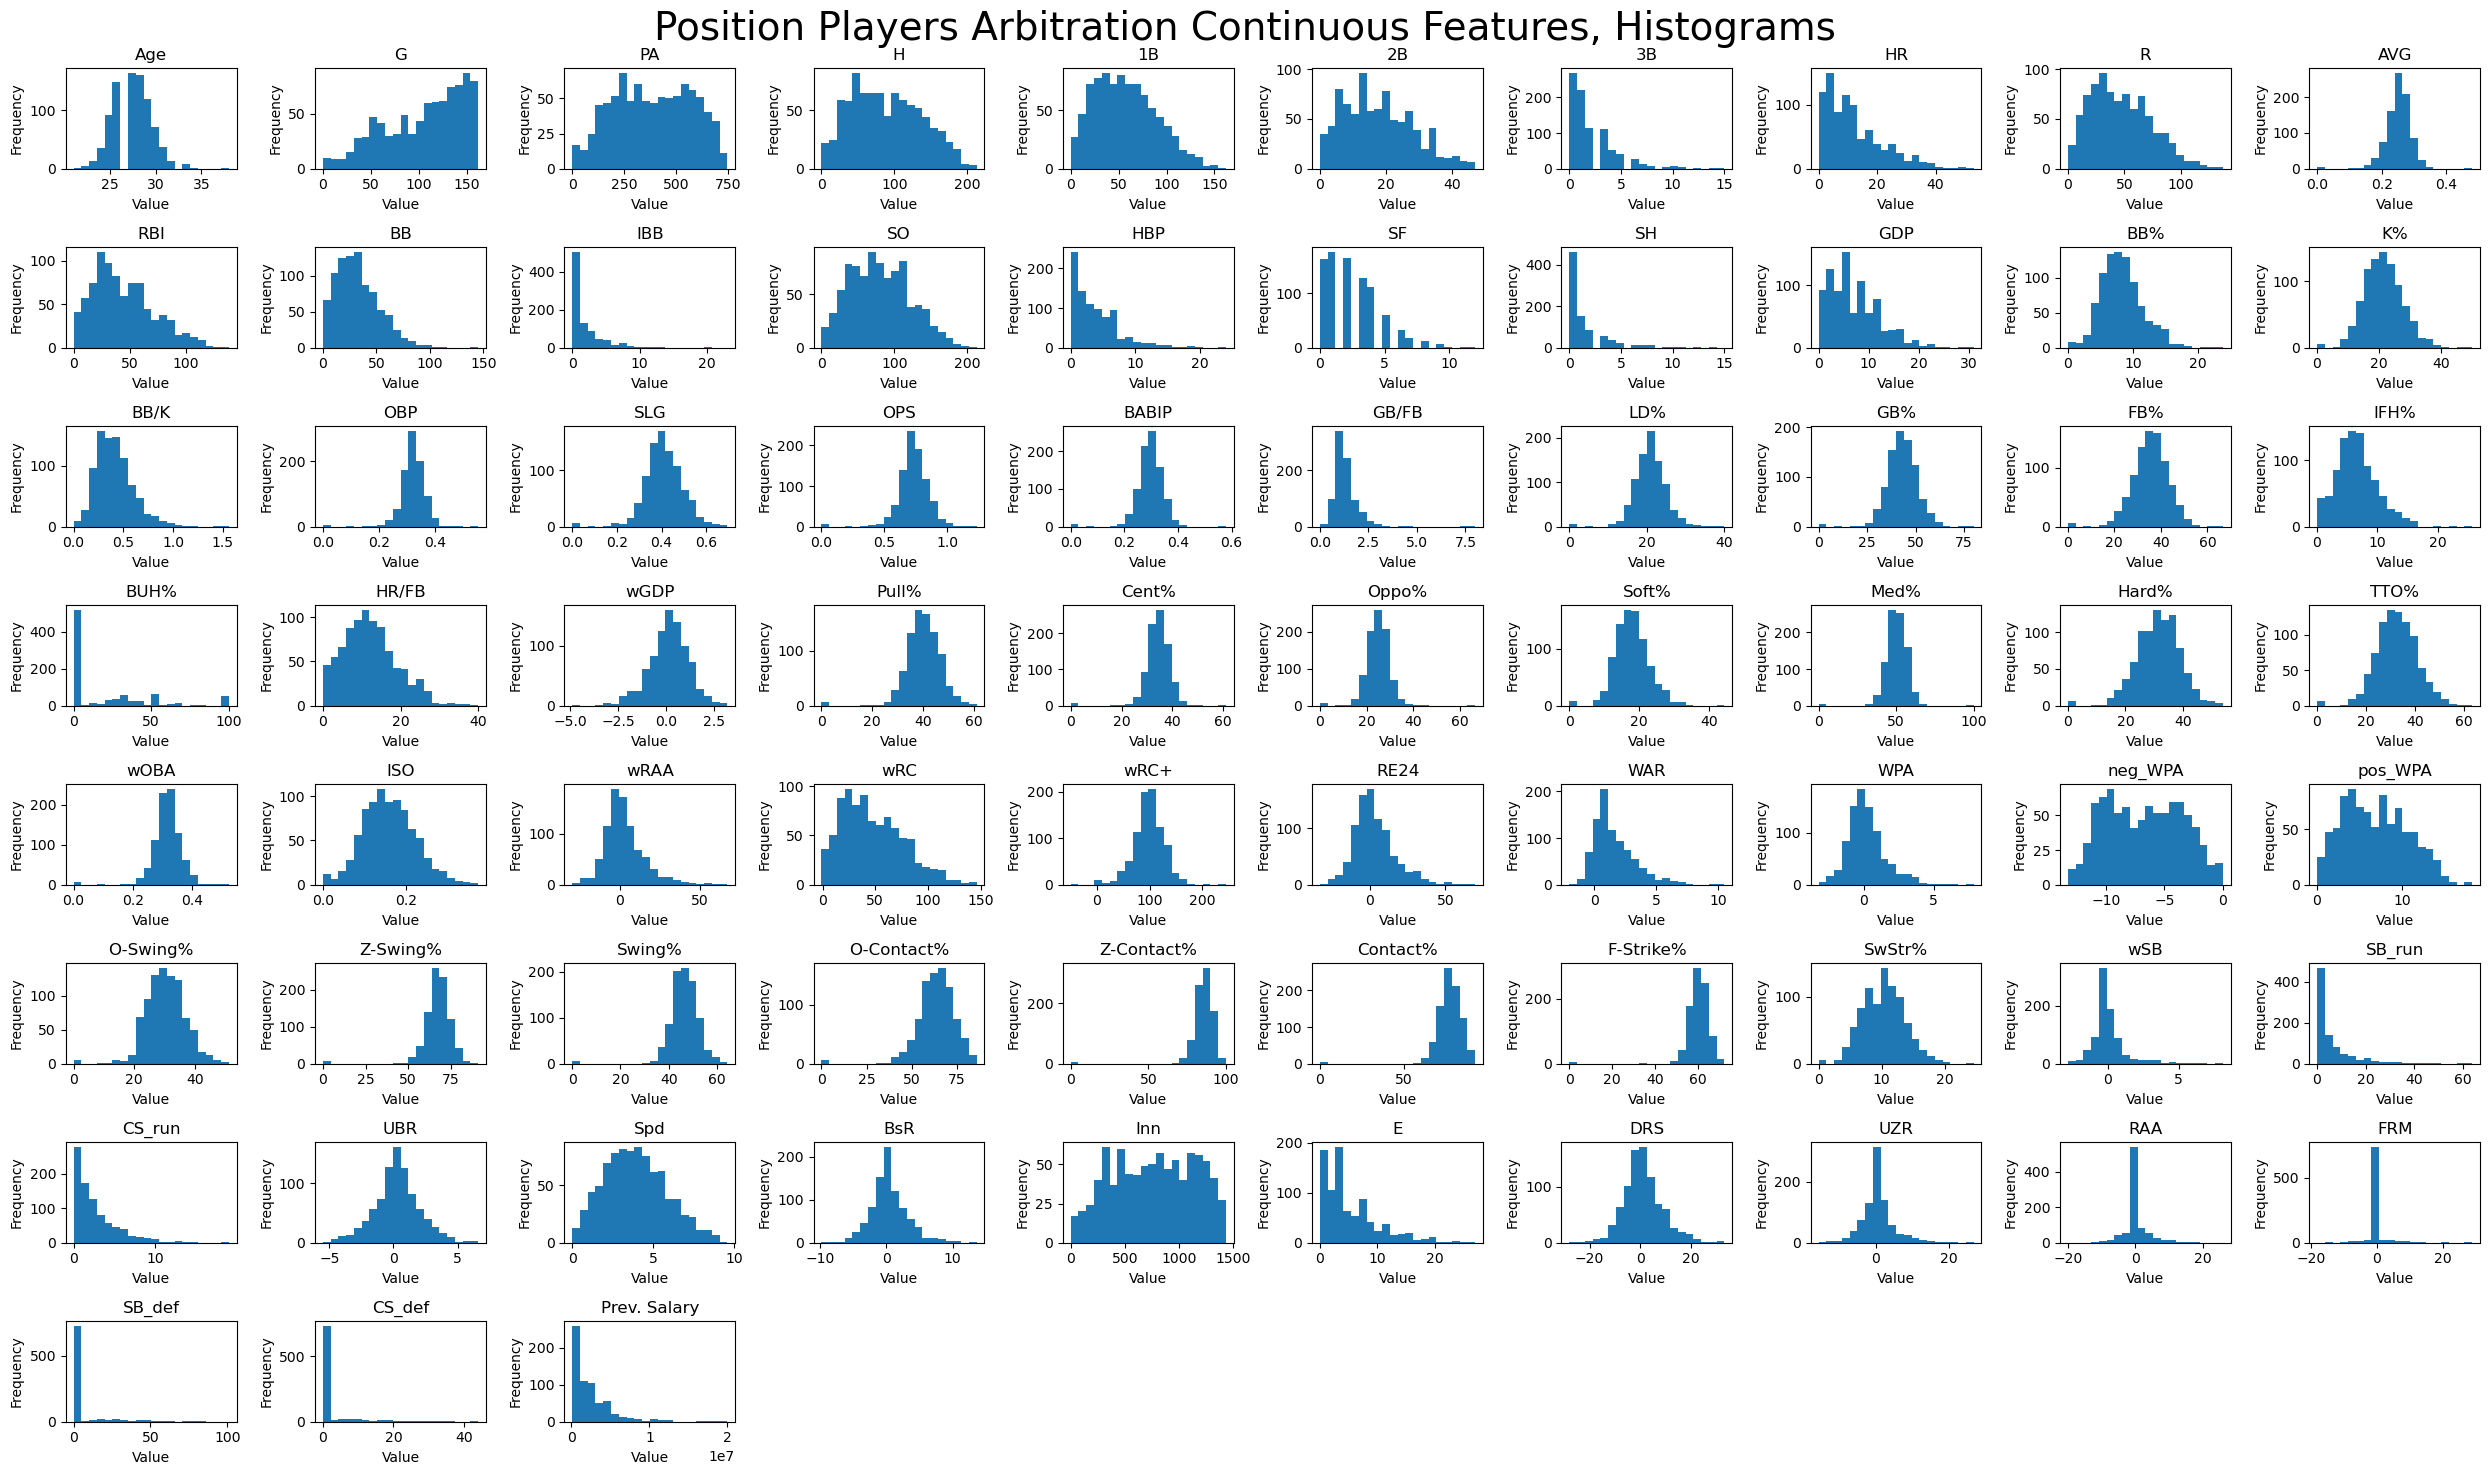

In [7]:
from hists import plot_histograms

# Visualize distributions of all continuous variables
cont_features = train_plyrs.iloc[:,5:]
plot_histograms(cont_features,'Position Players Arbitration Continuous Features, Histograms')

## Missing Values

In [8]:
# Find all missing values, training set
na_vals_train = train_plyrs.isna().sum()
na_vals_train[na_vals_train > 0]

Prev. Salary    218
dtype: int64

In [9]:
train_plyrs[train_plyrs['Prev. Salary'].isna()]

,Name,Prev. Season,Position,Service Time,Salary,Age,G,PA,H,1B,...,BsR,Inn,E,DRS,UZR,RAA,FRM,SB_def,CS_def,Prev. Salary
0,A.J. Ellis,2012,C,2,2000000,31,133,505,114,80,...,-3.3,1151.00,6,-6,0.0,0,-9.1,74,36,NaN
6,Aaron Hicks,2016,CF,3,1350000,26,123,361,71,49,...,-0.4,845.67,1,5,5.0,0,0.0,0,0,NaN
23,Adam Rosales,2011,2B,2,600000,28,24,68,6,4,...,-0.7,158.30,4,-1,-3.3,0,0.0,0,0,NaN
28,Adeiny Hechavarria,2015,SS,3,2625000,26,130,499,132,104,...,-1.0,1120.33,9,12,10.6,0,0.0,0,0,NaN
36,Alejandro De Aza,2012,OF,3,2075000,28,131,585,147,103,...,1.6,1132.40,3,-6,-3.1,0,0.0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,Xander Bogaerts,2016,SS,3,4500000,23,157,719,192,136,...,6.0,1378.67,12,-10,-2.4,-12,0.0,0,0,NaN
863,Yasmani Grandal,2015,C,3,2800000,26,115,426,83,55,...,-4.9,911.33,3,5,0.0,0,27.4,56,23,NaN
868,Yolmer Sanchez,2020,2B,5,1000000,28,12,21,5,1,...,-0.1,52.67,1,0,-0.3,-1,0.0,0,0,NaN
869,Yonder Alonso,2014,1B,3,1650000,27,84,288,64,37,...,1.1,631.30,2,9,2.1,0,0.0,0,0,NaN


In [10]:
# Find all missing values, test set
na_vals_test = test_plyrs.isna().sum()
na_vals_test[na_vals_test > 0]

Prev. Salary    6
dtype: int64

In [11]:
# Find all players with NA salaries in 2022
na_names = test_plyrs[test_plyrs['Prev. Salary'].isna()].Name
test_plyrs[test_plyrs['Prev. Salary'].isna()]

,Name,Prev. Season,Position,Service Time,Salary,Age,G,PA,H,1B,...,BsR,Inn,E,DRS,UZR,RAA,FRM,SB_def,CS_def,Prev. Salary
15,Christian Bethancourt,2022,C,3,1350000,30,101,333,80,52,...,-1.0,662.00,4,3,-0.5,1,2.4,17,13,NaN
27,Ildemaro Vargas,2022,SS,3,975000,30,63,222,55,37,...,0.5,516.67,5,5,1.8,5,0.0,0,0,NaN
42,Kyle Garlick,2022,RF,2,750000,30,66,162,35,23,...,1.1,254.67,1,-3,-3.0,-2,0.0,0,0,NaN
50,Luis Rengifo,2022,2B,3,2300000,25,127,511,129,86,...,1.4,1056.50,15,1,-2.0,-5,0.0,0,0,NaN
68,Rob Refsnyder,2022,RF,4,1200000,31,57,177,47,30,...,1.7,302.67,2,-5,-1.6,-2,0.0,0,0,NaN
80,Trayce Thompson,2022,OF,3,1450000,31,80,255,56,28,...,3.2,533.67,0,2,3.1,2,0.0,0,0,NaN


# Preprocessing

## Handling Missing Values

After handling missing values for some players (extensions), the rest are assumed to be players who were non-tendered in the past before reaching arbitration for the first time, or were signed to minor-league deals, thus making the league minimum if they played in the major leagues.

Any missing values will be imputed with the league minimum salary, which differs from year-to-year. The link to find minimum salary figures is here: https://www.baseball-reference.com/bullpen/Minimum_salary

In [12]:
# View missing values for each preceeding season
train_plyrs[train_plyrs['Prev. Salary'].isna()]['Prev. Season'].value_counts().sort_index()

2011    29
2012    41
2013    41
2014    36
2015    28
2016    34
2018     2
2019     3
2020     1
2021     3
Name: Prev. Season, dtype: int64

In [13]:
# Define league minimums for each preceeding season, fill in na previous salaires
minimums = {2011 : 414000, 
            2012: 480000, 
            2013: 480000, 
            2014: 480000, 
            2015: 507500,
            2016: 507500,
            2017: 535000,
            2018: 545000,
            2019: 545000,
            2020: 563500,
            2021: 563500}

train_plyrs['Prev. Salary'] = train_plyrs['Prev. Salary'].fillna(train_plyrs['Prev. Season'].map(minimums))

In [14]:
# Check: NA values in training set filled in with league minimums
print((train_plyrs.isna().sum() == 0).value_counts(),'\n')
train_plyrs[train_plyrs['Prev. Salary'] == 414000].head()

True    78
dtype: int64 



,Name,Prev. Season,Position,Service Time,Salary,Age,G,PA,H,1B,...,BsR,Inn,E,DRS,UZR,RAA,FRM,SB_def,CS_def,Prev. Salary
23,Adam Rosales,2011,2B,2,600000,28,24,68,6,4,...,-0.7,158.30,4,-1,-3.3,0,0.0,0,0,414000.0
97,Blake DeWitt,2011,2B,3,1100000,25,121,243,61,41,...,-0.4,360.67,7,-4,-3.9,0,0.0,0,0,414000.0
120,Brett Gardner,2011,OF,3,2800000,27,159,588,132,98,...,9.6,1250.30,5,23,26.7,0,0.0,0,0,414000.0
156,Casey McGehee,2011,3B,3,2538000,28,155,600,122,83,...,-8.2,1238.33,20,4,7.1,0,0.0,0,0,414000.0
180,Chris Getz,2011,2B,3,968000,27,118,429,97,88,...,2.1,920.33,7,-1,4.7,0,0.0,0,0,414000.0


In [15]:
# Fill in test set with league minimum for 2022
test_plyrs = test_plyrs.fillna(700000)

In [16]:
# Check: NA values in test set filled in with league minimum
print((test_plyrs.isna().sum() == 0).value_counts(),'\n')
test_plyrs[test_plyrs.Name.isin(na_names)]

True    78
dtype: int64 



,Name,Prev. Season,Position,Service Time,Salary,Age,G,PA,H,1B,...,BsR,Inn,E,DRS,UZR,RAA,FRM,SB_def,CS_def,Prev. Salary
15,Christian Bethancourt,2022,C,3,1350000,30,101,333,80,52,...,-1.0,662.00,4,3,-0.5,1,2.4,17,13,700000.0
27,Ildemaro Vargas,2022,SS,3,975000,30,63,222,55,37,...,0.5,516.67,5,5,1.8,5,0.0,0,0,700000.0
42,Kyle Garlick,2022,RF,2,750000,30,66,162,35,23,...,1.1,254.67,1,-3,-3.0,-2,0.0,0,0,700000.0
50,Luis Rengifo,2022,2B,3,2300000,25,127,511,129,86,...,1.4,1056.50,15,1,-2.0,-5,0.0,0,0,700000.0
68,Rob Refsnyder,2022,RF,4,1200000,31,57,177,47,30,...,1.7,302.67,2,-5,-1.6,-2,0.0,0,0,700000.0
80,Trayce Thompson,2022,OF,3,1450000,31,80,255,56,28,...,3.2,533.67,0,2,3.1,2,0.0,0,0,700000.0


In [17]:
train_plyrs

,Name,Prev. Season,Position,Service Time,Salary,Age,G,PA,H,1B,...,BsR,Inn,E,DRS,UZR,RAA,FRM,SB_def,CS_def,Prev. Salary
0,A.J. Ellis,2012,C,2,2000000,31,133,505,114,80,...,-3.3,1151.00,6,-6,0.0,0,-9.1,74,36,480000.0
1,A.J. Ellis,2013,C,3,3550000,32,115,448,93,65,...,-0.4,972.33,3,-4,0.0,0,-2.3,35,28,2000000.0
2,A.J. Ellis,2014,C,4,4250000,33,93,347,54,42,...,-8.0,773.67,4,-6,0.0,0,-14.0,48,16,3550000.0
3,A.J. Ellis,2015,C,5,4500000,34,63,217,43,27,...,-2.7,492.00,0,-5,0.0,0,-8.5,22,18,4250000.0
4,A.J. Pollock,2017,CF,5,7750000,29,112,466,113,60,...,2.6,873.33,1,6,1.3,1,0.0,0,0,6750000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,Yonder Alonso,2015,1B,4,2650000,28,103,402,100,76,...,-2.6,840.33,3,10,2.2,0,0.0,0,0,1650000.0
871,Yonder Alonso,2016,1B,5,4000000,29,156,532,122,81,...,-2.8,1174.33,5,-4,0.8,1,0.0,0,0,2650000.0
872,Zack Cozart,2014,SS,3,2350000,28,147,543,112,85,...,3.0,1274.33,10,16,13.0,0,0.0,0,0,480000.0
873,Zack Cozart,2015,SS,4,2925000,29,53,214,50,30,...,0.5,449.67,3,4,1.0,0,0.0,0,0,2350000.0


## (More) Feature Engineering

In [18]:
# Drop Name, Prev. Season, Statcast features
train_plyrs = train_plyrs.drop(['Name','Prev. Season'],axis=1)

test_plyr_names = test_plyrs.Name
test_plyrs = test_plyrs.drop(['Name','Prev. Season'],axis=1)

## Scaling, Normalization, OHC

From histograms generated to visualize how each of our continuous features are distributed, we define a ColumnTransformer object in SciKit Learn with StandardScaler, MinMaxScaler, and OneHotEncoder objects.

In [19]:
# Define all columns to appropriately scale, normalize, or OHC
ohc_cols = ['Position', 'Service Time']
minmax_cols = ['G', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 
    'HBP', 'SF', 'SH', 'GDP', 'BUH%', 'HR/FB', 'wRC', 'neg_WPA', 
    'pos_WPA', 'F-Strike%', 'SB_run', 'CS_run', 'Inn', 'E', 
    'SB_def', 'CS_def', 'Prev. Salary']

norm_cols = [i for i in train_plyrs.columns if i not in ohc_cols and i not in minmax_cols and i != 'Salary']

In [20]:
# Filter to X and y values, changing order to align with preprocessing steps
train_plyrs_y = np.array(train_plyrs.Salary)
train_plyrs_X = train_plyrs[minmax_cols + norm_cols + ohc_cols]

train_plyrs_X.head()

,G,PA,H,1B,2B,3B,HR,R,RBI,BB,...,wSB,UBR,Spd,BsR,DRS,UZR,RAA,FRM,Position,Service Time
0,133,505,114,80,20,1,13,44,52,65,...,-0.6,-0.8,1.2,-3.3,-6,0.0,0,-9.1,C,2
1,115,448,93,65,17,1,10,43,52,45,...,-1.2,0.6,2.0,-0.4,-4,0.0,0,-2.3,C,3
2,93,347,54,42,9,0,3,21,25,53,...,-0.4,-5.5,0.6,-8.0,-6,0.0,0,-14.0,C,4
3,63,217,43,27,9,0,7,24,21,32,...,-0.1,-2.9,1.1,-2.7,-5,0.0,0,-8.5,C,5
4,112,466,113,60,33,6,14,73,49,35,...,1.2,0.4,7.5,2.6,6,1.3,1,0.0,CF,5


In [21]:
# Create the ColumnTransformer with all transformations in one step
# Apply Normalization to normally distributed continuous features
# Apply MinMax Scaling to non-normally distributed continuous features

preprocessor = ColumnTransformer(transformers=[
    ('numeric_minmax', MinMaxScaler(), minmax_cols),
    ('numeric_standard', StandardScaler(), norm_cols),
    ('categorical_onehot', OneHotEncoder(handle_unknown = 'ignore'), ohc_cols)
])
preprocessor.fit(train_plyrs_X)

# Get column names from preprocessor (for feature importance)
column_names = preprocessor.get_feature_names_out(input_features=train_plyrs_X.columns)

# Transform the data
train_plyrs_X = preprocessor.transform(train_plyrs_X)
train_plyrs_X

array([[0.82098765, 0.67603748, 0.53521127, ..., 0.        , 0.        ,
        0.        ],
       [0.70987654, 0.59973226, 0.43661972, ..., 0.        , 0.        ,
        0.        ],
       [0.57407407, 0.46452477, 0.25352113, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.90740741, 0.72690763, 0.5258216 , ..., 0.        , 0.        ,
        0.        ],
       [0.32716049, 0.28647925, 0.23474178, ..., 1.        , 0.        ,
        0.        ],
       [0.74691358, 0.68005355, 0.54929577, ..., 0.        , 1.        ,
        0.        ]])

## Dataset Splitting

In [22]:
# Split training set into training-validation sets
X_train, X_valid, y_train, y_valid = train_test_split(train_plyrs_X, train_plyrs_y, test_size=0.25, random_state=64)

# Neural Net Building, Compiling

## Define Keras Neural Net, Train

### Define Parameters

In [23]:
# Params
n_epochs = 300
l_rate = 0.0005
num_cols = X_train.shape[1]

# Defines Keras Sequentual Model
arb_nnet = tf.keras.Sequential([
    tf.keras.layers.Dense(num_cols, activation='relu', input_shape=(num_cols,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

## Train

In [24]:
# Define optimizer and return metrics for neural net, compile
nn_optimizer = tf.keras.optimizers.Adam(learning_rate=l_rate)
nn_metrics = [tf.keras.metrics.MeanAbsoluteError(),
              tf.keras.metrics.MeanAbsolutePercentageError()]

arb_nnet.compile(optimizer= nn_optimizer,
          loss='mean_absolute_error',
          metrics=nn_metrics)

# Fit the neural net
history = arb_nnet.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=n_epochs, batch_size=24)

# Evaluate model on validation set, return metrics
loss_nn, mae_nn, mape_nn = arb_nnet.evaluate(X_valid, y_valid)


# Define DataFrame for loss and metrics over each epoch of training 
loss_df = pd.DataFrame(columns=['Epochs','train_MAE', 'val_MAE','train_MAPE','val_MAPE'])

# Return loss and mae values over time from training epochs
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

mae = history_dict['mean_absolute_error']
val_mae = history_dict['val_mean_absolute_error']

mape = history_dict['mean_absolute_percentage_error']
val_mape = history_dict['val_mean_absolute_percentage_error']

# Add all metrics to dictionary, convert to Dataframe & return
epochs = [i for i in range(1, n_epochs + 1)]

loss_dict = {'train_MAE':mae, 'val_MAE': val_mae, 'train_MAPE': mape, 'val_MAPE': val_mape}

nnet_loss = pd.DataFrame.from_dict(loss_dict).reset_index().melt(id_vars=['index'])
nnet_loss['index'] = nnet_loss['index'] + 1

Epoch 1/300
28/28 [==============================] - 4s 27ms/step - loss: 3807074.2500 - mean_absolute_error: 3807074.2500 - mean_absolute_percentage_error: 99.9999 - val_loss: 4126116.7500 - val_mean_absolute_error: 4126116.7500 - val_mean_absolute_percentage_error: 99.9996
Epoch 2/300
28/28 [==============================] - 0s 12ms/step - loss: 3807033.7500 - mean_absolute_error: 3807033.7500 - mean_absolute_percentage_error: 99.9980 - val_loss: 4125986.2500 - val_mean_absolute_error: 4125986.7500 - val_mean_absolute_percentage_error: 99.9942
Epoch 3/300
28/28 [==============================] - 0s 11ms/step - loss: 3806553.0000 - mean_absolute_error: 3806553.0000 - mean_absolute_percentage_error: 99.9767 - val_loss: 4124708.2500 - val_mean_absolute_error: 4124708.2500 - val_mean_absolute_percentage_error: 99.9427
Epoch 4/300
28/28 [==============================] - 0s 11ms/step - loss: 3803222.7500 - mean_absolute_error: 3803222.7500 - mean_absolute_percentage_error: 99.8315 - val_l

Epoch 31/300
28/28 [==============================] - 0s 8ms/step - loss: 1460116.6250 - mean_absolute_error: 1460116.6250 - mean_absolute_percentage_error: 39.9417 - val_loss: 1533261.7500 - val_mean_absolute_error: 1533261.7500 - val_mean_absolute_percentage_error: 39.5481
Epoch 32/300
28/28 [==============================] - 0s 6ms/step - loss: 1417628.0000 - mean_absolute_error: 1417628.0000 - mean_absolute_percentage_error: 39.5752 - val_loss: 1518998.7500 - val_mean_absolute_error: 1518998.7500 - val_mean_absolute_percentage_error: 40.5624
Epoch 33/300
28/28 [==============================] - 0s 6ms/step - loss: 1435064.8750 - mean_absolute_error: 1435064.8750 - mean_absolute_percentage_error: 40.6267 - val_loss: 1511245.2500 - val_mean_absolute_error: 1511245.2500 - val_mean_absolute_percentage_error: 40.6098
Epoch 34/300
28/28 [==============================] - 0s 6ms/step - loss: 1439771.5000 - mean_absolute_error: 1439771.5000 - mean_absolute_percentage_error: 40.6469 - val_l

Epoch 61/300
28/28 [==============================] - 0s 6ms/step - loss: 1208801.5000 - mean_absolute_error: 1208801.5000 - mean_absolute_percentage_error: 33.6078 - val_loss: 1363458.0000 - val_mean_absolute_error: 1363458.0000 - val_mean_absolute_percentage_error: 38.8519
Epoch 62/300
28/28 [==============================] - 0s 6ms/step - loss: 1242019.7500 - mean_absolute_error: 1242019.7500 - mean_absolute_percentage_error: 34.3779 - val_loss: 1359064.2500 - val_mean_absolute_error: 1359064.2500 - val_mean_absolute_percentage_error: 38.3096
Epoch 63/300
28/28 [==============================] - 0s 6ms/step - loss: 1228865.5000 - mean_absolute_error: 1228865.5000 - mean_absolute_percentage_error: 33.0904 - val_loss: 1355867.5000 - val_mean_absolute_error: 1355867.5000 - val_mean_absolute_percentage_error: 37.8939
Epoch 64/300
28/28 [==============================] - 0s 5ms/step - loss: 1223514.3750 - mean_absolute_error: 1223514.3750 - mean_absolute_percentage_error: 33.5440 - val_l

Epoch 91/300
28/28 [==============================] - 0s 6ms/step - loss: 1107754.0000 - mean_absolute_error: 1107754.0000 - mean_absolute_percentage_error: 30.5088 - val_loss: 1263784.3750 - val_mean_absolute_error: 1263784.5000 - val_mean_absolute_percentage_error: 36.4112
Epoch 92/300
28/28 [==============================] - 0s 5ms/step - loss: 1132575.5000 - mean_absolute_error: 1132575.5000 - mean_absolute_percentage_error: 31.0276 - val_loss: 1261869.1250 - val_mean_absolute_error: 1261869.1250 - val_mean_absolute_percentage_error: 36.2627
Epoch 93/300
28/28 [==============================] - 0s 5ms/step - loss: 1103003.7500 - mean_absolute_error: 1103003.7500 - mean_absolute_percentage_error: 30.1414 - val_loss: 1260499.2500 - val_mean_absolute_error: 1260499.2500 - val_mean_absolute_percentage_error: 36.6031
Epoch 94/300
28/28 [==============================] - 0s 5ms/step - loss: 1076022.2500 - mean_absolute_error: 1076022.2500 - mean_absolute_percentage_error: 29.8584 - val_l

Epoch 121/300
28/28 [==============================] - 0s 8ms/step - loss: 1029616.0000 - mean_absolute_error: 1029616.0000 - mean_absolute_percentage_error: 26.9693 - val_loss: 1178232.5000 - val_mean_absolute_error: 1178232.5000 - val_mean_absolute_percentage_error: 33.0876
Epoch 122/300
28/28 [==============================] - 0s 7ms/step - loss: 1011897.6875 - mean_absolute_error: 1011897.6875 - mean_absolute_percentage_error: 27.0898 - val_loss: 1173583.5000 - val_mean_absolute_error: 1173583.5000 - val_mean_absolute_percentage_error: 33.6237
Epoch 123/300
28/28 [==============================] - 0s 7ms/step - loss: 989782.5625 - mean_absolute_error: 989782.5625 - mean_absolute_percentage_error: 26.5779 - val_loss: 1169385.3750 - val_mean_absolute_error: 1169385.3750 - val_mean_absolute_percentage_error: 33.7124
Epoch 124/300
28/28 [==============================] - 0s 7ms/step - loss: 1034636.3750 - mean_absolute_error: 1034636.3750 - mean_absolute_percentage_error: 27.7763 - val

Epoch 151/300
28/28 [==============================] - 0s 6ms/step - loss: 923719.5000 - mean_absolute_error: 923719.5000 - mean_absolute_percentage_error: 24.5623 - val_loss: 1074201.6250 - val_mean_absolute_error: 1074201.6250 - val_mean_absolute_percentage_error: 31.2444
Epoch 152/300
28/28 [==============================] - 0s 5ms/step - loss: 931866.1250 - mean_absolute_error: 931866.1250 - mean_absolute_percentage_error: 24.4861 - val_loss: 1068100.6250 - val_mean_absolute_error: 1068100.6250 - val_mean_absolute_percentage_error: 30.7473
Epoch 153/300
28/28 [==============================] - 0s 5ms/step - loss: 920028.1875 - mean_absolute_error: 920028.1875 - mean_absolute_percentage_error: 24.1195 - val_loss: 1062164.0000 - val_mean_absolute_error: 1062164.0000 - val_mean_absolute_percentage_error: 30.8856
Epoch 154/300
28/28 [==============================] - 0s 5ms/step - loss: 915501.1875 - mean_absolute_error: 915501.1875 - mean_absolute_percentage_error: 24.7760 - val_loss:

Epoch 181/300
28/28 [==============================] - 0s 11ms/step - loss: 823934.1250 - mean_absolute_error: 823934.1250 - mean_absolute_percentage_error: 21.6311 - val_loss: 974871.9375 - val_mean_absolute_error: 974871.9375 - val_mean_absolute_percentage_error: 28.2663
Epoch 182/300
28/28 [==============================] - 0s 8ms/step - loss: 797434.8125 - mean_absolute_error: 797434.8125 - mean_absolute_percentage_error: 21.5474 - val_loss: 949362.7500 - val_mean_absolute_error: 949362.7500 - val_mean_absolute_percentage_error: 28.8581
Epoch 183/300
28/28 [==============================] - 0s 10ms/step - loss: 803482.3125 - mean_absolute_error: 803482.3125 - mean_absolute_percentage_error: 21.9934 - val_loss: 957019.7500 - val_mean_absolute_error: 957019.7500 - val_mean_absolute_percentage_error: 28.5105
Epoch 184/300
28/28 [==============================] - 0s 9ms/step - loss: 813674.8125 - mean_absolute_error: 813674.8125 - mean_absolute_percentage_error: 22.4908 - val_loss: 941

Epoch 211/300
28/28 [==============================] - 0s 9ms/step - loss: 682019.5625 - mean_absolute_error: 682019.5625 - mean_absolute_percentage_error: 19.7810 - val_loss: 844406.9375 - val_mean_absolute_error: 844406.9375 - val_mean_absolute_percentage_error: 26.8394
Epoch 212/300
28/28 [==============================] - 0s 8ms/step - loss: 709651.3125 - mean_absolute_error: 709651.3125 - mean_absolute_percentage_error: 19.5849 - val_loss: 842499.1250 - val_mean_absolute_error: 842499.1250 - val_mean_absolute_percentage_error: 26.6836
Epoch 213/300
28/28 [==============================] - 0s 8ms/step - loss: 706379.5000 - mean_absolute_error: 706379.5000 - mean_absolute_percentage_error: 19.3418 - val_loss: 841317.9375 - val_mean_absolute_error: 841317.9375 - val_mean_absolute_percentage_error: 26.9253
Epoch 214/300
28/28 [==============================] - 0s 8ms/step - loss: 684825.0000 - mean_absolute_error: 684825.0000 - mean_absolute_percentage_error: 19.1550 - val_loss: 84095

Epoch 241/300
28/28 [==============================] - 0s 7ms/step - loss: 655743.1250 - mean_absolute_error: 655743.1250 - mean_absolute_percentage_error: 18.4225 - val_loss: 758887.7500 - val_mean_absolute_error: 758887.7500 - val_mean_absolute_percentage_error: 24.9239
Epoch 242/300
28/28 [==============================] - 0s 6ms/step - loss: 610545.4375 - mean_absolute_error: 610545.4375 - mean_absolute_percentage_error: 17.6704 - val_loss: 757346.1875 - val_mean_absolute_error: 757346.1875 - val_mean_absolute_percentage_error: 25.0346
Epoch 243/300
28/28 [==============================] - 0s 8ms/step - loss: 619879.0000 - mean_absolute_error: 619879.0000 - mean_absolute_percentage_error: 17.5059 - val_loss: 759546.0000 - val_mean_absolute_error: 759546.0000 - val_mean_absolute_percentage_error: 25.2036
Epoch 244/300
28/28 [==============================] - 0s 8ms/step - loss: 583428.5625 - mean_absolute_error: 583428.5625 - mean_absolute_percentage_error: 17.0380 - val_loss: 75673

Epoch 271/300
28/28 [==============================] - 0s 13ms/step - loss: 577873.4375 - mean_absolute_error: 577873.4375 - mean_absolute_percentage_error: 16.4079 - val_loss: 724095.7500 - val_mean_absolute_error: 724095.7500 - val_mean_absolute_percentage_error: 24.5122
Epoch 272/300
28/28 [==============================] - 0s 12ms/step - loss: 548295.7500 - mean_absolute_error: 548295.7500 - mean_absolute_percentage_error: 16.0787 - val_loss: 707470.8750 - val_mean_absolute_error: 707470.8750 - val_mean_absolute_percentage_error: 24.5347
Epoch 273/300
28/28 [==============================] - 0s 16ms/step - loss: 579170.3750 - mean_absolute_error: 579170.3750 - mean_absolute_percentage_error: 16.5801 - val_loss: 713076.4375 - val_mean_absolute_error: 713076.4375 - val_mean_absolute_percentage_error: 24.1910
Epoch 274/300
28/28 [==============================] - 0s 12ms/step - loss: 556641.1875 - mean_absolute_error: 556641.1875 - mean_absolute_percentage_error: 15.9019 - val_loss: 7

7/7 [==============================] - 0s 5ms/step - loss: 690039.9375 - mean_absolute_error: 690039.9375 - mean_absolute_percentage_error: 24.0311


# Performance, Training Data

In [25]:
# Isolate MAE and MAPE from dataframe w/ loss values
nnet_mae = nnet_loss[(nnet_loss.variable == 'train_MAE')| (nnet_loss.variable == 'val_MAE')]
nnet_mape = nnet_loss[(nnet_loss.variable == 'train_MAPE')| (nnet_loss.variable == 'val_MAPE')]

## Learning Curves

In [26]:
sns.set(rc={"figure.figsize":(12, 6)})

Text(0.5, 1.0, 'Train-Val MAE Loss/Epoch, Position Players')

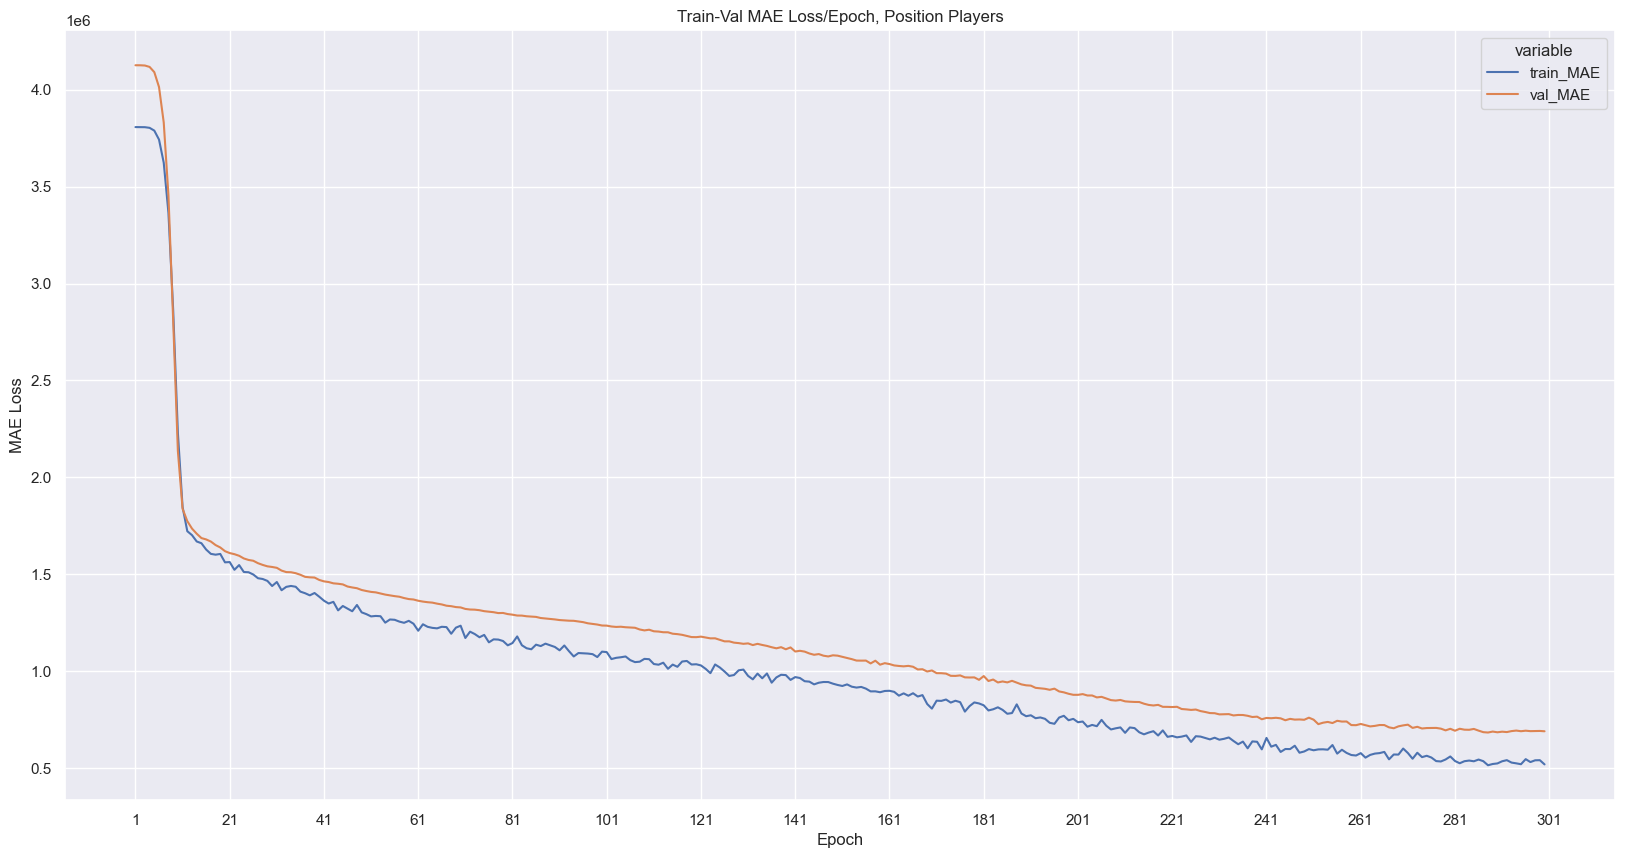

In [27]:
# Create learning curve: MAE per epoch
plt.figure(figsize=(20,10))
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.xticks((np.arange(1,502,20)))
sns.lineplot(data=nnet_mae, x = "index", y="value", hue="variable").set_title('Train-Val MAE Loss/Epoch, Position Players')

Text(0.5, 1.0, 'Train-Val MAPE Loss/Epoch, Position Players')

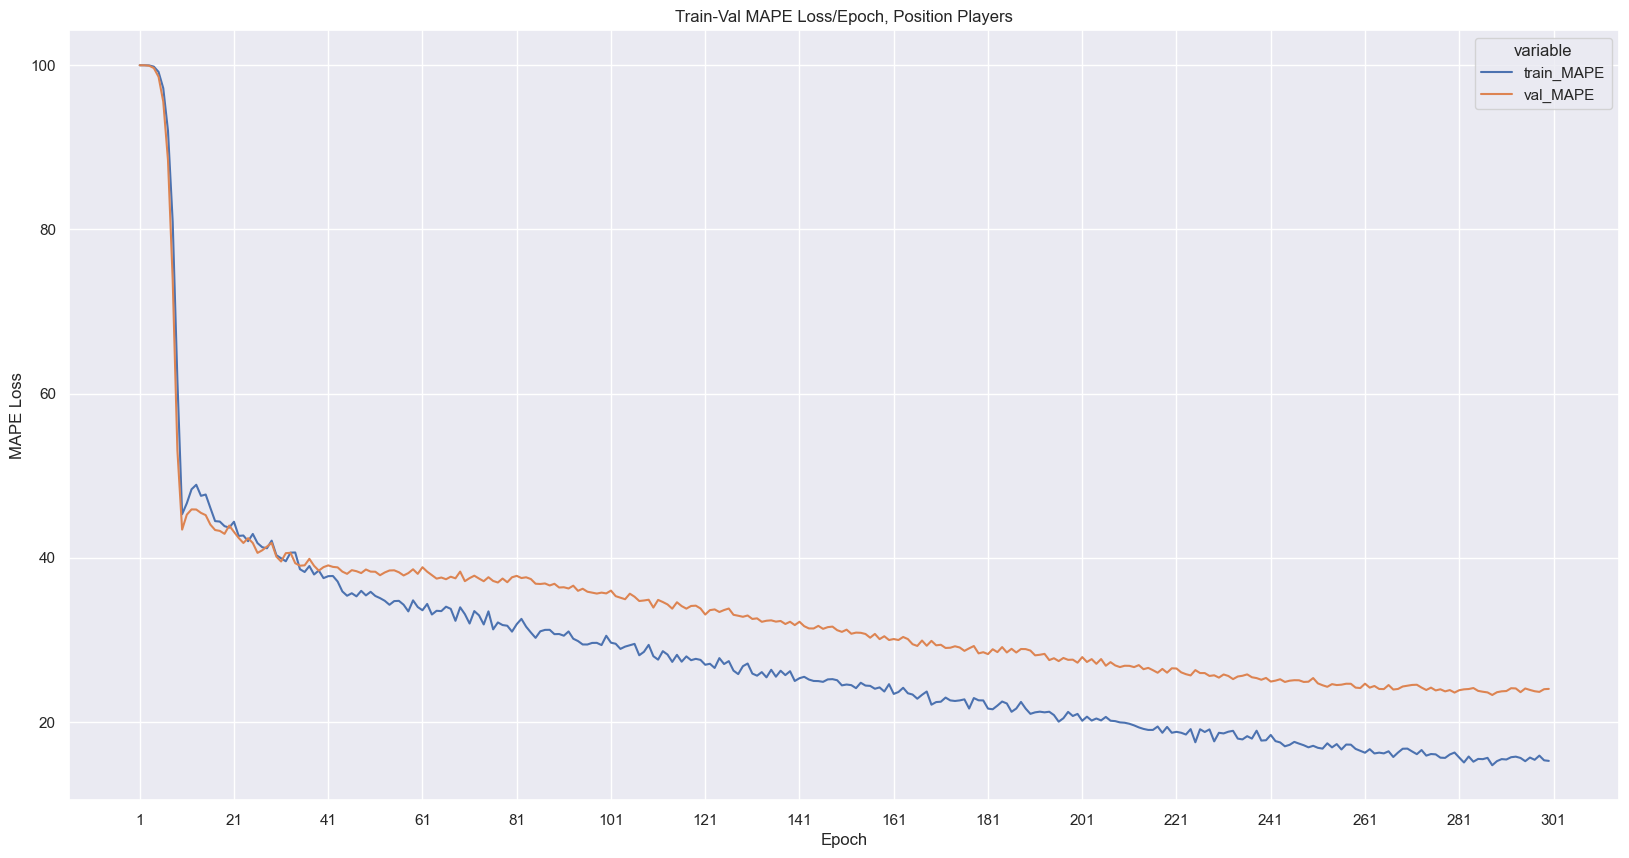

In [28]:
# Create learning curve: MAPE per epoch
plt.figure(figsize=(20,10))
plt.xlabel('Epoch')
plt.ylabel('MAPE Loss')
plt.xticks((np.arange(1,502,20)))
sns.lineplot(data=nnet_mape, x = "index", y="value", hue="variable").set_title('Train-Val MAPE Loss/Epoch, Position Players')

## Feature Importance

In [29]:
feature_names = [i.replace('numeric_minmax__', '').replace('numeric_standard__','').replace('categorical_onehot__','') for i in column_names]

Permutation explainer: 657it [03:12,  3.33it/s]                                 


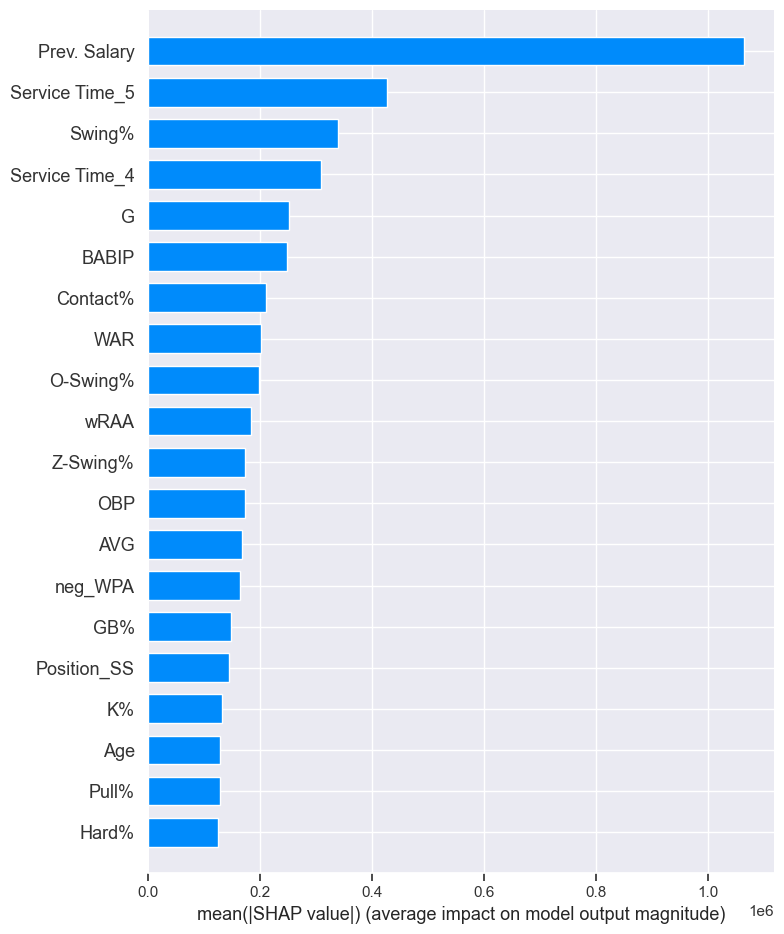

In [30]:
# SHAP feature importance
explainer = shap.Explainer(arb_nnet, X_train)
shap_values = explainer(X_train)

# Summary plot (bar plot of feature importance)
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names = feature_names)

# Performance, Test Data (Predicting 2023 Salaries)

In [31]:
test_plyr_names = test_plyr_names

In [32]:
# Split into x and y
test_plyrs_y = np.array(test_plyrs.Salary)
test_plyrs_X = test_plyrs.drop('Salary',axis=1)[minmax_cols + norm_cols + ohc_cols]


# Fit and transform the data
test_plyrs_X = preprocessor.transform(test_plyrs_X)

In [33]:
# Helper function: Rounds all predicted figures to nearest multiple of 10,000
# Done to "clean" predictions
def round_nearest_multiple(number, multiple = 10000):
    return multiple * round(number / multiple)

In [34]:
# Define DataFrame to compare 2023 salary and NNet predicted 2023 Salary
arb23_preds = pd.DataFrame(columns = ["Name", 'Position','Service Time','2023 Salary', 'Predicted 2023 Salary'])
arb23_preds.Name = test_plyr_names
arb23_preds.Position = test_plyrs.Position
arb23_preds['Service Time'] = test_plyrs['Service Time']
arb23_preds['2023 Salary'] = test_plyrs_y

# Predict Salaries, add to Dataframe
y_test_pred = arb_nnet.predict(test_plyrs_X)
arb23_preds['Predicted 2023 Salary'] = [round_nearest_multiple(float(i)) for i in y_test_pred]

arb23_preds

3/3 [==============================] - 0s 8ms/step


,Name,Position,Service Time,2023 Salary,Predicted 2023 Salary
0,Abraham Toro,3B,2,1250000,1350000
1,Adalberto Mondesi,SS,5,3045000,5780000
2,Alex Verdugo,RF,4,6300000,5730000
3,Amed Rosario,SS,5,7800000,8180000
4,Andrew Knizner,C,3,1100000,1230000
...,...,...,...,...,...
83,Tyler O'Neill,LF,4,4950000,5300000
84,Victor Caratini,C,5,2800000,2650000
85,Vladimir Guerrero Jr.,1B,3,14500000,10800000
86,Will Smith,C,3,5250000,3560000


## Metrics

In [35]:
# Calculate "error" of test set
error_test = sum(np.abs(arb23_preds['2023 Salary'] - arb23_preds['Predicted 2023 Salary']))
med_ae = int(np.median(np.abs(arb23_preds['Predicted 2023 Salary'] - np.median(arb23_preds['Predicted 2023 Salary']))))
print('Total Absolute Error Test Set:', error_test)
print('MAE Test Set:', error_test // arb23_preds.shape[0])
print('Median Absolute Deviation, Test Set:', med_ae)

Total Absolute Error Test Set: 81025000
MAE Test Set: 920738
Median Absolute Deviation, Test Set: 1255000


In [36]:
# Lowest predicted salary
arb23_preds[arb23_preds['Predicted 2023 Salary'] == min(arb23_preds['Predicted 2023 Salary'])]

,Name,Position,Service Time,2023 Salary,Predicted 2023 Salary
52,Mauricio Dubon,2B,2,1400000,770000


In [37]:
# Highest predicted salary
arb23_preds[arb23_preds['Predicted 2023 Salary'] == max(arb23_preds['Predicted 2023 Salary'])]

,Name,Position,Service Time,2023 Salary,Predicted 2023 Salary
38,Juan Soto,LF,4,23000000,21170000


## Visualizations

Text(0.5, 1.0, '2023 Salary vs. Predicted 2023 Salary: Position Players')

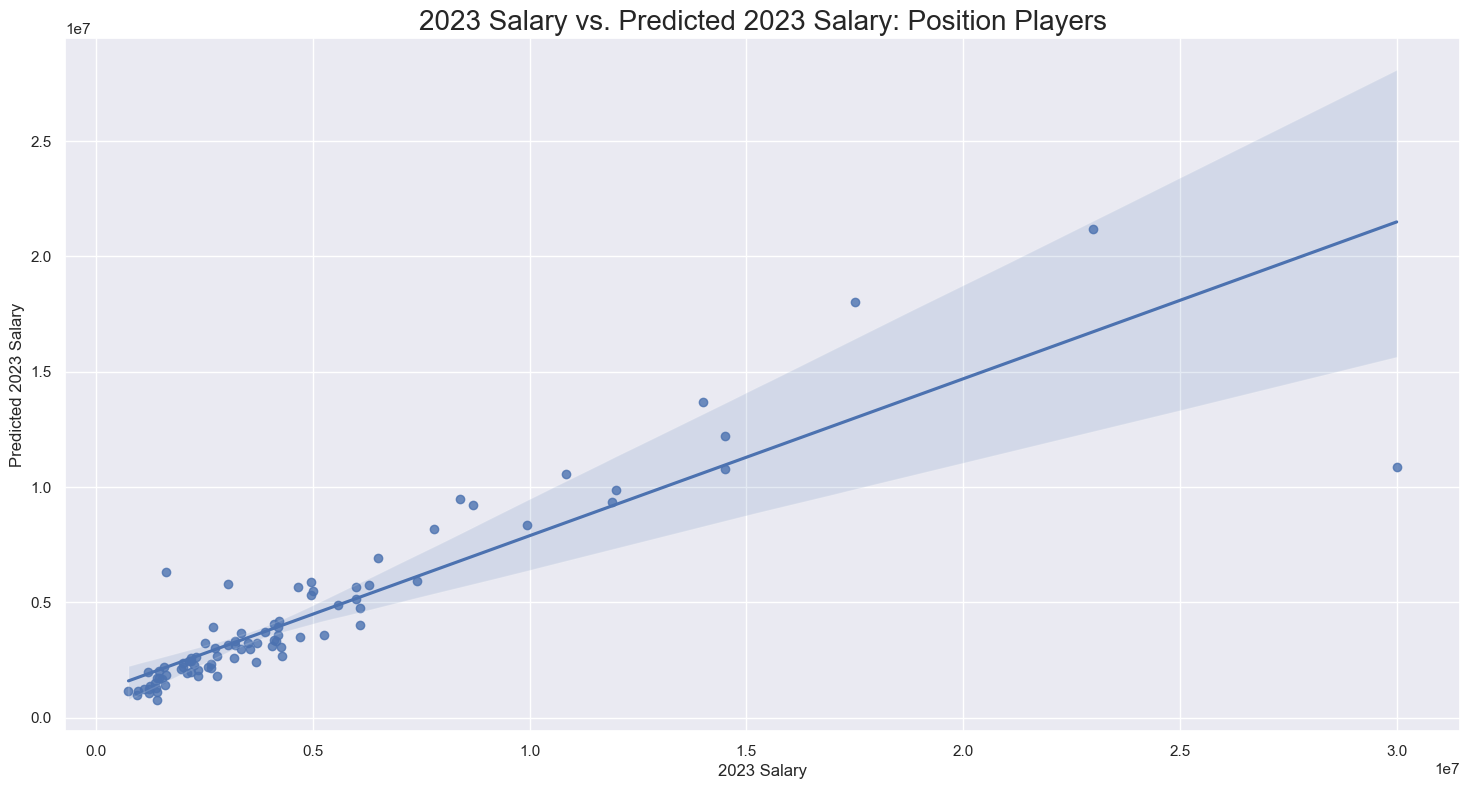

In [38]:
# Create plot actual vs. predicted salary, visualize error spread
sns.set(rc={"figure.figsize":(18, 9)})
sns.regplot(arb23_preds, x='2023 Salary', y='Predicted 2023 Salary').set_title('2023 Salary vs. Predicted 2023 Salary: Position Players', fontsize = 20)

Text(0.5, 1.0, '2023 Salary vs. Predicted 2023 Salary: Position Players (Colored)')

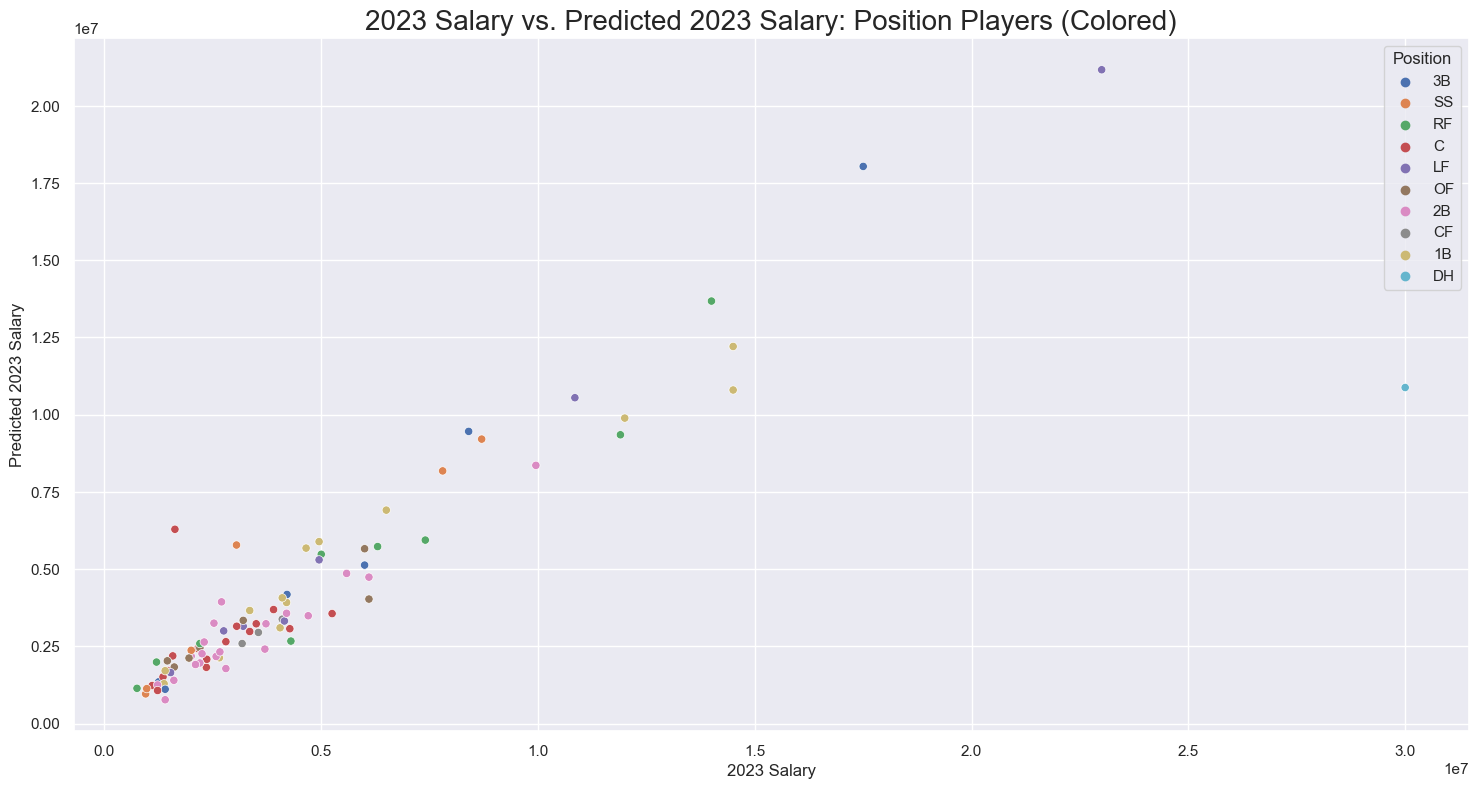

In [39]:
# Create scatterplot of actual vs. predicted salaries, color by Position
sns.scatterplot(arb23_preds, 
                x='2023 Salary', y='Predicted 2023 Salary', 
                hue='Position').set_title('2023 Salary vs. Predicted 2023 Salary: Position Players (Colored)', fontsize = 20)

Text(0.5, 1.0, '2023 Salary vs. Predicted 2023 Salary: Position Players (Colored & Dotted)')

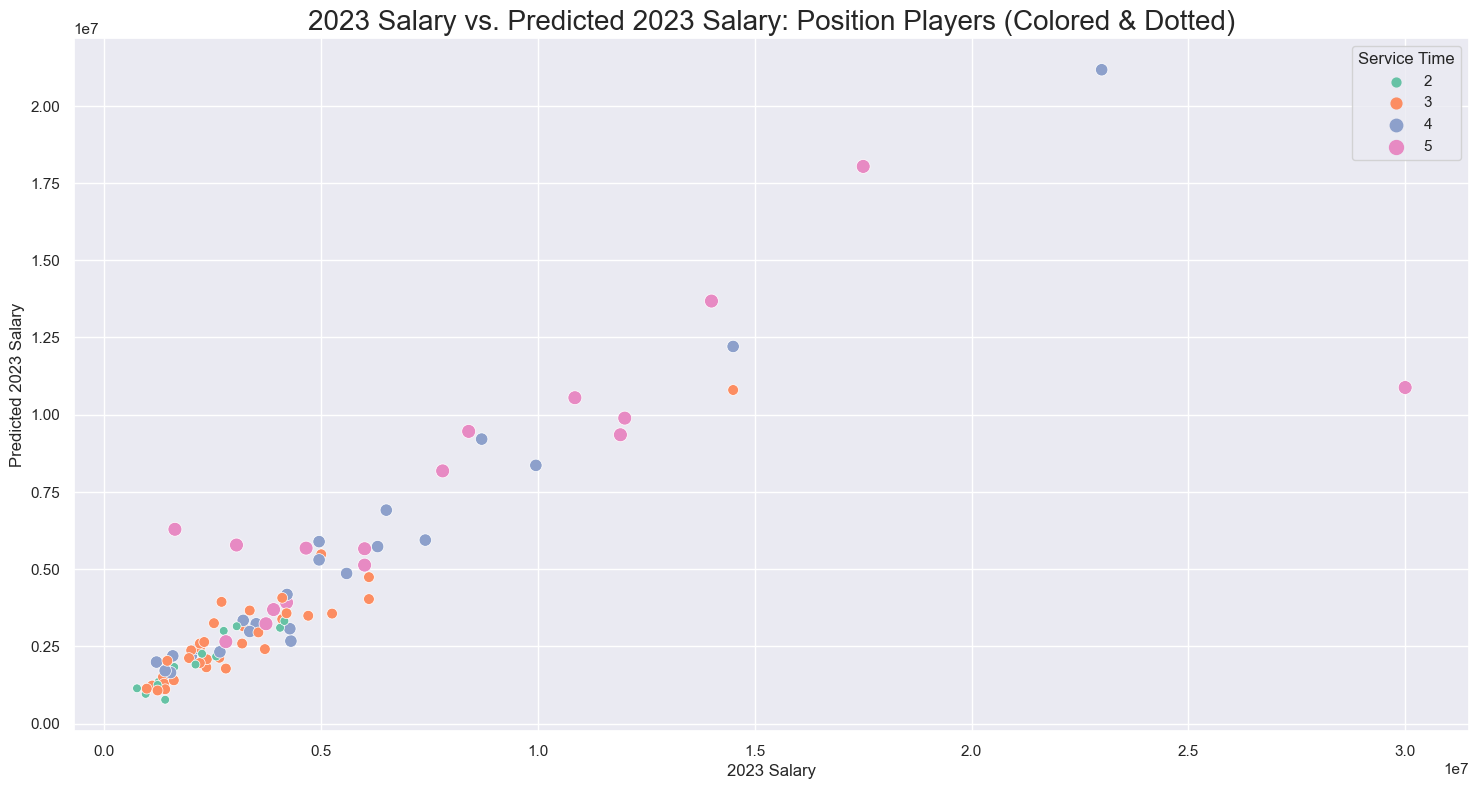

In [40]:
# Create scatterplot of actual vs. predicted salaries, color and size by service time
sns.scatterplot(arb23_preds, 
                x='2023 Salary', y='Predicted 2023 Salary', 
                hue='Service Time',
                size = 'Service Time', sizes= {2:40,3:60,4:80,5:100}, 
                palette="Set2").set_title('2023 Salary vs. Predicted 2023 Salary: Position Players (Colored & Dotted)', fontsize = 20)

In [44]:
# Write predictions to Excel file
with pd.ExcelWriter('Predictions/preds.xlsx', mode='a') as writer:  
    arb23_preds.to_excel(writer, sheet_name='pos_players2')